**ImageNet dataset을 이용한 AlexNet 구현**



AlexNet은 ILSCRC-2012의 ImageNet dataset을 사용하여 대량의 고화질 이미지를 빠르게 학습하는 네트워크이다.Input image data가 동일한 resolution을 갖게 하기 위해서, 256x256 크기의 이미지로 resize 했다.

AelxNet은 5개의 Convolutional Layer와 3개의 fully-connected layer로 구성되어 있다. Activation function에는 Relu를 사용하였고, 각 Convolutional Layer에는 Maxpooling을, FC layer에는 dropout을 사용하였다.

또한, 특이하게 Local Response Normalization(LRN)이라는 noramlization layer를 두었고, 이를 사용하면 측면 억제라는 강한 자극(짙은 색깔)이 주변에 영향을 미치는 현상을 억제시켜주는 방법이라고 한다. 현재는 batch normalization을 사용해서 예방한다. 

Overfitting을 피하기 위해 Data augmentation과 dropout을 사용하였다.
Data augmentation은 256x256 이미지를 227x227 크기의 이미지가 되도록 random으로 crop하거나 상하반전을 줘서 이미지가 조금 달라지게 만들었다. 또한, RGB pexel에 PCA를 적용하여 이미지에 변화를 주었다. 첫번째 Convolutional Layer의 Input 이미지는 3x227x227를 사용하였다. (3은 RGB, 227는 크기)
Dropout은 FC layer1과 FC layer2에 적용시켰다.

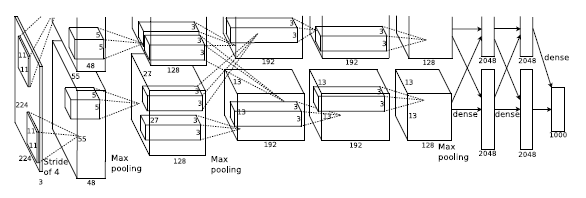

그림에 224x224로 적혀 있지만 실제로는 227x227이 맞다고 한다.

Input 이미지는 3x227x227이고, 첫번째 Convolutional Layer의 input으로 들어간다.

첫번째 Layer는 C1:Convolutional Layer로 96개의 output channel로 구성되어있고, kernel size=11x11, stride=4을 사용하였다. 첫번째 Layer를 통과하면 3x227x227  ->  96x55x55로 크기가 바뀌게 된다.

두번째 Layer는 S1:max pooling을 사용하였고, kernel size는 3x3, stride=2를 사용하였다. 두번째 Layer를 통과하면  96x55x55 -> 96x27x27의 크기가 된다.

이와 함께 LRN을 적용하였다 .크기에는 영향을 미치지 않는다. 96x27x27 -> 96x27x27

세번째 Layer는 C2:Convolutional Layer로 256개의 output channel로 구성되어있고, kernel size=5x5, stride=1, padding=2를 사용하였다. 세번째 Layer를 통과하면 96x27x27 -> 256x27x27이 된다.

네번째 Layer는 S2:max pooling을 사용하였고, kernel size는 3x3, stride=2를 사용하였다. 네번째 Layer를 통과하면  256x27x27 -> 256x13x13의 크기가 된다.

역시 LRN을 적용하였다. 크기에는 영향을 미치지 않는다. 256x13x13 -> 256x13x13

다섯번째 Layer는 C3:Convolutional Layer로 384개의 output channel로 구성되어있고, kernel size=3x3, stride=1, padding=1를 사용하였다. 다섯번째 Layer를 통과하면 256x13x13 -> 384x13x13이 된다.

여섯번째 Layer는 C4:Convolutional Layer로 384개의 output channel로 구성되어있고, kernel size=3x3, stride=1, padding=1를 사용하였다. 어섯번째 Layer를 통과하면 384x13x13 -> 384x13x13이 된다.

일곱번째 Layer는 C5:Convolutional Layer로 256개의 output channel로 구성되어있고, kernel size=3x3, stride=1, padding=1를 사용하였다. 일곱번째 Layer를 통과하면 384x13x13 -> 256x13x13이 된다.

여덟번째 Layer는 S3:max pooling을 사용하였고, kernel size는 3x3, stride=2를 사용하였다. 여덟번째 Layer를 통과하면  256x13x13 -> 256x6x6의 크기가 된다.

아홉번째 Layer는 F1:Fully Connected Layer로 4096개의 노드를 output으로 가지며, 이 논문에서는 relu를 activation function으로 사용하였다.

열번째 Layer는 F2:Fully Connected Layer로 4096개의 노드를 output으로 가지며, 이 논문에서는 relu를 activation function으로 사용하였다.

Output Layer는 F1:Fully Connected Layer로 1000개의 노드를 output node를 갖는다. 1000개의 class로 나뉘어 있기 때문이다.

**** 
Convolutional layer의 output size는 

(W - F + 2P) / S + 1 

의 식을 사용하여 계산할 수 있다. W는 input 이미지의 width/height 크기이며, F는 kernel(filter) size, P는 padding, 그리고 S는 stride를 의미한다.

**Pytorch를 사용해서 AlexNet 구현해보기**

구현을 위한 Dataset은 STL10의 dataset을 사용하였다.
논문에서는 2개의 GPU를 사용하였지만, 현재 작업환경을 고려해서 단일 GPU에서의 AlexNet을 구현하였다.

In [ ]:
# 먼저 필요한 Library import 하기

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils import data

import torchvision.datasets as datasets
import torchvision.transforms as transforms


# 필요한 parameter를 미리 세팅한다.
random_seed=4
learning_rate=0.0001
batch_size=32
epochs=100

image_size=227
n_classes=1000   

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
datapath='/data'

if not os.path.exists(datapath):
  os.mkdir(datapath)

#transforms로 원하는 형태의 dataset으로 변형해준다.
tfData=transforms.Compose([transforms.Resize((256,256)),
                           transforms.RandomCrop(227),  # 227 size로 random crop 
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                           ])

# Dataset 다운로드
train_data = datasets.STL10(datapath, split='train', download='True', transform=tfData)
test_data = datasets.STL10(datapath, split='test', download='True', transform=tfData)

print(train_data.data.shape)
print(test_data.data.shape)

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /data/stl10_binary.tar.gz to /data
Files already downloaded and verified
(5000, 3, 96, 96)
(8000, 3, 96, 96)


**AlexNet 구현하기**

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    # Convolutional Layer 및 pooling, LRN 정의
    self.conv1=nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)  # Input size는 3x227x227으로 3은 RGB, 227은 width, height를 의미한다.
                                                                                    # output size는 96x55x55 이다.
    self.max_pool1=nn.MaxPool2d(kernel_size=3, stride=2)  # 96x55x55 -> 96x27x27
    self.norm1=nn.LocalResponseNorm(size=5, k=2)  # default로 alpha=0.0001, beta-0.75이다.

    self.conv2=nn.Conv2d(96, 256, kernel_size=5, stride= 1, padding=2) # 96x27x27 -> 256x27x27
    self.max_pool2=nn.MaxPool2d(kernel_size=3, stride=2)  # 256x27x27 -> 256x13x13
    self.norm2=nn.LocalResponseNorm(size=5, k=2)

    self.conv3=nn.Conv2d(256,384, kernel_size=3, stride=1, padding=1)  # 256x13x13 -> 384x13x13
    self.conv4=nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1) # 384x13x13 -> 384x13x13

    self.conv5=nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1) # 384x13x13 -> 256x13x13
    self.max_pool3=nn.MaxPool2d(kernel_size=3, stride=2) # 256x13x13 -> 256x6x6

    # Fully Connected Layer 및 dropout 정의
    self.fc1=nn.Linear(in_features=256*6*6, out_features=4096)  # 256x6x6 -> 4096
    self.dropout1=nn.Dropout(p=0.5)  # dropout 0.5

    self.fc2=nn.Linear(4096, 4096)  # 4096 -> 4096
    self.dropout2=nn.Dropout(p=0.5)  # dropout 0.5

    self.fc3=nn.Linear(4096, n_classes)  # 4096 -> 1000
 


  def forward(self, x):
    x=F.relu(self.conv1(x))
    x=self.max_pool1(x)
    x=self.norm1(x)
    x=F.relu(self.conv2(x))
    x=self.max_pool2(x)
    x=self.norm2(x)
    x=F.relu(self.conv3(x))
    x=F.relu(self.conv4(x))
    x=F.relu(self.conv5(x))
    x=self.max_pool3(x)
    x=x.view(-1, 256*6*6)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.dropout1(x)
    x=self.fc2(x)
    x=F.relu(x)
    x=self.dropout2(x)
    x=self.fc3(x)

    return F.softmax(x, dim=1)




In [ ]:
model=AlexNet(1000).to(DEVICE)
print(model)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (f

In [ ]:
from torchsummary import summary
summary(model, input_size=(3,227,227))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
         MaxPool2d-2           [-1, 96, 27, 27]               0
 LocalResponseNorm-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
         MaxPool2d-5          [-1, 256, 13, 13]               0
 LocalResponseNorm-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
            Conv2d-8          [-1, 384, 13, 13]       1,327,488
            Conv2d-9          [-1, 256, 13, 13]         884,992
        MaxPool2d-10            [-1, 256, 6, 6]               0
           Linear-11                 [-1, 4096]      37,752,832
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 4096]      16,781,312
          Dropout-14                 [-

**Train**

In [ ]:
#optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.CrossEntropyLoss()

In [ ]:
def train(train_loader, model, criterion, optimizer, device):

  running_loss=0
  count=0
  correct=0

  model.train()
  for batch in train_loader:
    X=batch[0]
    y_true=batch[1]

    X=X.to(device)
    y_true=y_true.to(device)   

    # Forward
    y_pred=model(X)
    loss=criterion(y_pred, y_true)
    running_loss+=loss.item()
    batch_correct=torch.argmax(y_pred, dim=1).eq(y_true).sum().item()
    batch_count=len(X)


    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count+=batch_count
    correct+=batch_correct
  
  epoch_loss=running_loss / len(train_loader.dataset)
  epoch_accuracy=correct/count
  return model, optimizer, epoch_loss, epoch_accuracy   


In [ ]:
#train(train_loader, model, criterion, optimizer, DEVICE)

In [ ]:
def evaluation(test_loader, model, criterion, device):

  running_loss=0
  count=0
  correct=0
  
  model.eval()
  for batch in test_loader:
    X=batch[0]
    y_true=batch[1]

    X=X.to(device)
    y_true=y_true.to(device)

    # Forward
    y_pred=model(X)
    loss=criterion(y_pred, y_true)
    batch_correct=torch.argmax(y_pred, dim=1).eq(y_true).sum().item()
    batch_count=len(X)
    running_loss+=loss.item()*X.size(0)

    count+=batch_count
    correct+=batch_correct


  epoch_loss=running_loss/len(test_loader.dataset)
  epoch_accuracy=correct/count  

  return model, epoch_loss, epoch_accuracy



In [ ]:
#evaluation(test_loader, model, criterion,DEVICE)

In [ ]:
# train % validation

train_losses=[]
test_losses=[]

train_acc=[]
test_acc=[]
for epoch in range(epochs):
  model, optimizer, train_loss, train_accuracy=train(train_loader, model, criterion, optimizer, DEVICE)
  train_acc.append(train_accuracy)
  train_losses.append(train_loss)

  with torch.no_grad():
     model, test_loss, test_accuracy=evaluation(test_loader, model, criterion, DEVICE)
     test_acc.append(test_accuracy)
     test_losses.append(test_loss)

  if epoch%10==0:
      print('epoch: ', epoch, 'train_loss: ', train_loss, 'test_loss: ', test_loss)
      print('          train accuracy: ', train_accuracy, 'test accuracy: ', test_accuracy)




epoch:  0 train_loss:  0.21409239168167113 test_loss:  6.809470558166504
          train accuracy:  0.0952 test accuracy:  0.1
epoch:  10 train_loss:  0.21383237600326538 test_loss:  6.809470558166504
          train accuracy:  0.1 test accuracy:  0.1
epoch:  20 train_loss:  0.2138136260032654 test_loss:  6.809470558166504
          train accuracy:  0.1 test accuracy:  0.1
epoch:  30 train_loss:  0.21383237600326538 test_loss:  6.809470558166504
          train accuracy:  0.1 test accuracy:  0.1
epoch:  40 train_loss:  0.21383237600326538 test_loss:  6.809470558166504
          train accuracy:  0.1 test accuracy:  0.1
epoch:  50 train_loss:  0.21383237600326538 test_loss:  6.809470558166504
          train accuracy:  0.1 test accuracy:  0.1
epoch:  60 train_loss:  0.2138136260032654 test_loss:  6.809470558166504
          train accuracy:  0.1 test accuracy:  0.1
epoch:  70 train_loss:  0.21379487600326538 test_loss:  6.809470558166504
          train accuracy:  0.1 test accuracy:  0.1


AlexNet으로 학습을 진행하였지만, accuracy 10%로 굉장히 낮았고 수렴도 하지못하였다. learning rate을 0.1~0.0001로 변화시켜봤지만 특별한 수렴점을 찾지 못했다.

참고

https://wolfy.tistory.com/241